In [13]:
#https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
#first walkthrough python hdbscan instructions

In [1]:
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
from qupath_filter_viz_functions import fiveDimStackedBar

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
data = pd.read_csv('test files/5_dim_results_ii.csv')

In [3]:
rgb_data = data[['ratio_red', 'ratio_green', 'ratio_blue','ratio_cyan', 'ratio_orange']].to_numpy()

In [4]:
#run hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,
                            #min_samples=1,
                            cluster_selection_epsilon=0.03,
                            gen_min_span_tree=True)
clusterer.fit(rgb_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.03,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [5]:
#add cluster labels and probability to input dataframe
#cells returned as noice set to c_label == -1

label_dict = dict(zip(data['cell_index'],clusterer.labels_))
prob_dict = dict(zip(data['cell_index'],clusterer.probabilities_))

data['c_label'] = data['cell_index'].apply(lambda x:label_dict.get(x))
data['c_probability'] = data['cell_index'].apply(lambda x:prob_dict.get(x))

In [6]:
#save labelled data
data.to_csv(r'test files\5_dim_hdb_result_epsilon.csv',index=False)

**WORKING WITH CLUSTERING DATA FUNCTIONALITY**

In [7]:
#return clusters in size order
pivot = data.groupby('c_label').count().sort_values(by='cell_index',ascending=False)[['cell_index']]
index = [-1] + pivot.index.drop([-1]).tolist()
pivot = pivot.reindex(index)

In [8]:
#gen dataframe of all root and leaf clusters
df = clusterer.condensed_tree_.to_pandas()

In [9]:
def addCellIndex(child,size):
    '''map cell_index from input dataframe to child value in condensed_tree dataframe'''
    
    if size == 1:
        cell_index = 'cell_'+str(child)
    else:
        cell_index = None
    
    return cell_index

df['cell_index'] = df[['child','child_size']].apply(lambda x:addCellIndex(*x),axis=1)

model_output_cluster = dict(zip(data['cell_index'],data['c_label']))

df['output_cluster'] = df['cell_index'].apply(lambda x:model_output_cluster.get(x))

In [10]:
#add column mapping selected_cluster output to cluster as indexed in condensed tree  

tree_cluster = {}

for select_cluster in pivot.index[1:]:
    slice_df = df[df['output_cluster']==select_cluster]
    cluster_node = slice_df['parent'].unique().min()
    
    tree_cluster[select_cluster] = cluster_node

df['tree_selected_cluster'] = df['output_cluster'].apply(lambda x:tree_cluster.get(x))

In [11]:
#derive node types for viz

cluster_df = df[df['child_size'] > 1]
single_cell = df[df['child_size'] == 1]

selected_cluster_node = list(tree_cluster.values())
root_node = [df.iloc[0].get('parent')]
branch_node = list(set(cluster_df['parent']).intersection(set(cluster_df['child']))- set(selected_cluster_node))
leaf_node = list(set(cluster_df['child']) - set(branch_node))
noise_node = list(set(df[df['output_cluster']== -1]['child']))
single_cell_node = list(set(single_cell['child'])- set(noise_node))

In [12]:
def genEdges(nodes,df): 
    '''networkx inputs edges as list of tuples
    filter dataframe and tuple columns'''
    
    def tupleValues(x,y):
        return (x,y)
    
    def filterCells(x):
        if x in nodes:
            return 'Y'
    
    df['inc_cell'] = df['child'].apply(lambda x:filterCells(x))
    
    df_filter = df[df['inc_cell'] == 'Y']
    edges = list(df_filter[['parent','child']].apply(lambda x:tupleValues(*x),axis=1))
    
    return edges

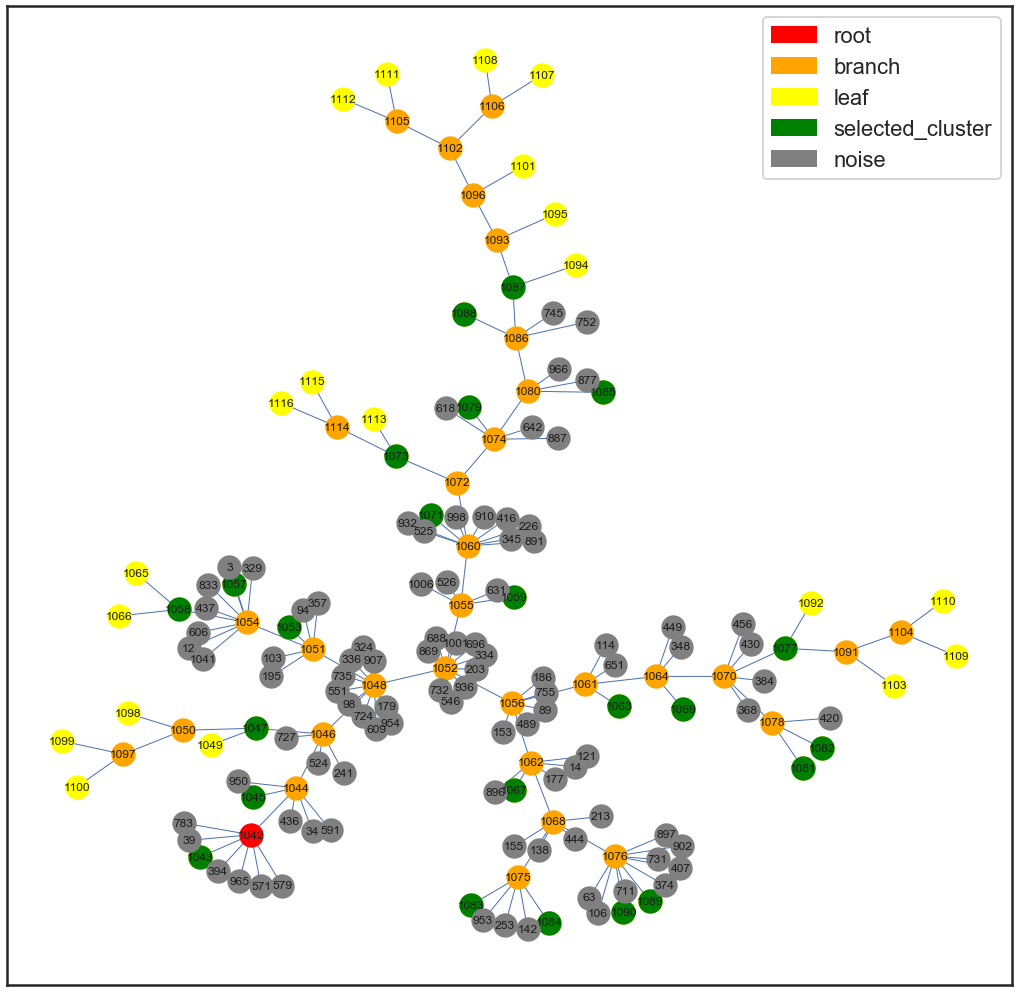

In [14]:
#generate networkx graph viz 
G = nx.Graph()

#declare nodes
nodes = root_node+branch_node+leaf_node+selected_cluster_node+noise_node

G.add_nodes_from(nodes)

edges = genEdges(nodes,df)
df = df.drop(columns='inc_cell')

G.add_edges_from(edges)

plt.figure(figsize=(18,18))
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist = root_node, cmap=plt.get_cmap('jet'), node_color = 'red', node_size = 500)
nx.draw_networkx_nodes(G, pos, nodelist = branch_node, cmap=plt.get_cmap('jet'), node_color = 'orange',node_size = 500)
nx.draw_networkx_nodes(G, pos, nodelist = leaf_node, cmap=plt.get_cmap('jet'), node_color = 'yellow', node_size = 500)
nx.draw_networkx_nodes(G, pos, nodelist = selected_cluster_node, cmap=plt.get_cmap('jet'), node_color = 'green', node_size = 500)
nx.draw_networkx_nodes(G, pos, nodelist = noise_node, cmap=plt.get_cmap('jet'), node_color = 'grey',node_size = 500)
#nx.draw_networkx_nodes(G, pos, nodelist = single_cell_node, cmap=plt.get_cmap('jet'), node_color = 'blue', node_size = 500)


nx.draw_networkx_edges(G, pos,edgelist=edges, edge_color='b',arrows=False)

nx.draw_networkx_labels(G, pos)

red_patch = mpatches.Patch(color='red', label='root')
orange_patch = mpatches.Patch(color='orange', label='branch')
yellow_patch = mpatches.Patch(color='yellow', label='leaf')
green_patch = mpatches.Patch(color='green', label='selected_cluster')
grey_patch = mpatches.Patch(color='grey', label='noise')
#blue_patch = mpatches.Patch(color='blue', label='single_cell_node')
plt.legend(handles=[red_patch,
                    orange_patch,
                    yellow_patch,
                    green_patch,
                    grey_patch,
                    #blue_patch
                   ])

plt.show()

In [15]:
def extractCells(node,df):
    '''return list of successor cells by index'''
    
    #generate digraph so can traverse successor clusters from root
    DG = nx.DiGraph()

    #add all nodes
    #species not important but just need complete hierarchy
    nodes = root_node+branch_node+leaf_node+selected_cluster_node+noise_node+single_cell_node

    DG.add_nodes_from(nodes)

    edges = genEdges(nodes,df)
    df = df.drop(columns='inc_cell')

    DG.add_edges_from(edges)
    
    #return all successor nodes
    successors = list(nx.nodes(nx.dfs_tree(DG, node)))[1:]

    single_cells = []

    #return only single cell successor nodes as list
    for i in successors:
        if df[df['child']==i].get('child_size').tolist() == [1]:
            single_cells.append(i) 

        
    #map child value to cell_index
    cell_index_dict = dict(zip(df['child'],df['cell_index']))
    def cellIndex(child):
        cell_index = cell_index_dict.get(child)
        return cell_index

    extract_cells = list(map(cellIndex, single_cells))
    
    return extract_cells

In [16]:
def nodeFilter(df,node_cells):
    '''input df and list of clusters to filter'''
    
    if type(node_cells) != list:
        print('Error: cluster input must be list type')
        return None
      
    def incCluster(x):
        if x in node_cells:
            return 'Y'
        else:
            return 'N'
    
    df['cluster_bool'] = df['cell_index'].apply(lambda x:incCluster(x))
    
    return df

In [17]:
data = data.sort_values(by='ratio_red',ascending=False)

In [18]:
cells = extractCells(1064,df)
data = nodeFilter(data,cells)
fiveDimStackedBar(data[data['cluster_bool']=='Y'],False,'cluster_bool')

Loading BokehJS ...

In [19]:
cells = extractCells(1070,df)
data = nodeFilter(data,cells)
fiveDimStackedBar(data[data['cluster_bool']=='Y'],False,'cluster_bool')

Loading BokehJS ...

In [20]:
cells = extractCells(1078,df)
data = nodeFilter(data,cells)
fiveDimStackedBar(data[data['cluster_bool']=='Y'],False,'cluster_bool')

Loading BokehJS ...

In [21]:
cells = extractCells(1082,df)
data = nodeFilter(data,cells)
fiveDimStackedBar(data[data['cluster_bool']=='Y'],False,'cluster_bool')

Loading BokehJS ...